In [1]:
%matplotlib inline
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [2]:
print(sys.version)
print(tf.version.VERSION)
print(tfp.__version__)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
1.14.0
0.7.0


In [3]:
seed = 0
random_state = 0
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# Toy data generation
*  [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [4]:
n_samples = int(1e4)

n_features = 20
n_classes = 2

n_informative = 5
n_redundant = 2

x, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=n_classes,
    random_state=random_state)

y = tfk.utils.to_categorical(y).astype(np.int64)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2 / 0.8)

In [5]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_valid = minmax.transform(x_valid)
x_test = minmax.transform(x_test)

# Data Visualization

In [6]:
num_vis = min(len(x_test), 500)
vis_indices = np.random.choice(np.arange(len(x_test)), num_vis)
x_vis = x_test[vis_indices]
y_vis = y_test[vis_indices]

In [7]:
# df = {'x{}'.format(i): x_vis[:, i] for i in [1, 3, 5, 7, 9]}
df = {'x{}'.format(i): x_vis[:, i] for i in range(0, n_features, 4)}
variables = list(df.keys())
print(variables)
df['y'] = y_vis[:, 1]
df = pd.DataFrame(df)

['x0', 'x4', 'x8', 'x12', 'x16']


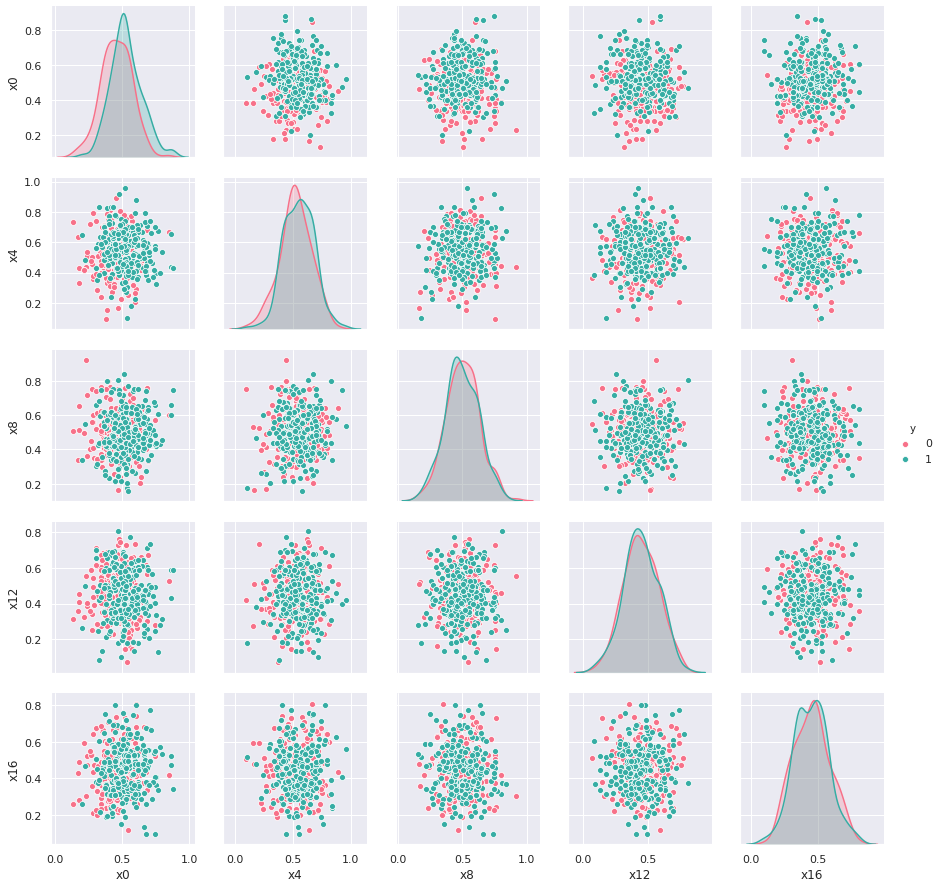

In [8]:
sns.pairplot(df, hue='y', vars=variables, palette="husl")

Text(0.5, 1.0, 't-SNE')

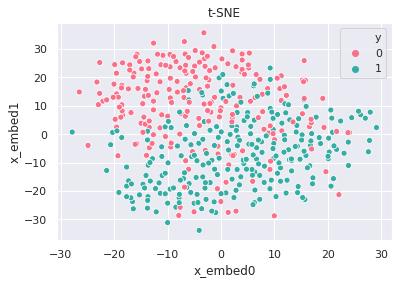

In [9]:
tsne = TSNE(random_state=random_state)
x_embed = tsne.fit_transform(x_vis)
df['x_embed0'] = x_embed[:, 0]
df['x_embed1'] = x_embed[:, 1]
ax = sns.scatterplot(data=df, x='x_embed0', y='x_embed1', hue='y', palette="husl")
ax.set_title("t-SNE")

# Create deterministic model

In [12]:
def plot_learning_curve(history, title=None):
    kwargs = {'ls': '--', 'marker': 'o'}

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    axarr[0].plot(history.history['loss'], label='Training', **kwargs)
    axarr[0].plot(history.history['val_loss'], label="Validation", **kwargs)
    axarr[0].set_title("Loss")
    axarr[0].set_xlabel('Epoch')
    axarr[0].legend()

    axarr[1].plot(history.history['acc'], label='Training', **kwargs)
    axarr[1].plot(history.history['val_acc'], label="Validation", **kwargs)
    axarr[1].set_title("Accuracy")
    axarr[1].set_xlabel('Epoch')
    axarr[1].legend()
    
    if title is not None:
        fig.suptitle(title)

In [13]:
def run_experiment(model,
                   loss,
                   title=None,
                   learning_rate=0.01,
                   epochs=100,
                   batch_size=256):
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
                  loss=loss,
                  metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(x_valid, y_valid),
        verbose=False)


    loss, acc = model.evaluate(x_test, y_test, verbose=False)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    
    
    # plotting
    plot_learning_curve(history, title)
    
    return history

### Shallow

In [14]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfkl.Dense(n_classes),
    tfkl.Softmax(),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 42        
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0         
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


W0707 18:26:35.043123 140136108504896 deprecation.py:323] From /home/slowmoyang/Installations/anaconda3/envs/py36-tf114/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Loss: 0.3748
Accuracy: 0.8590


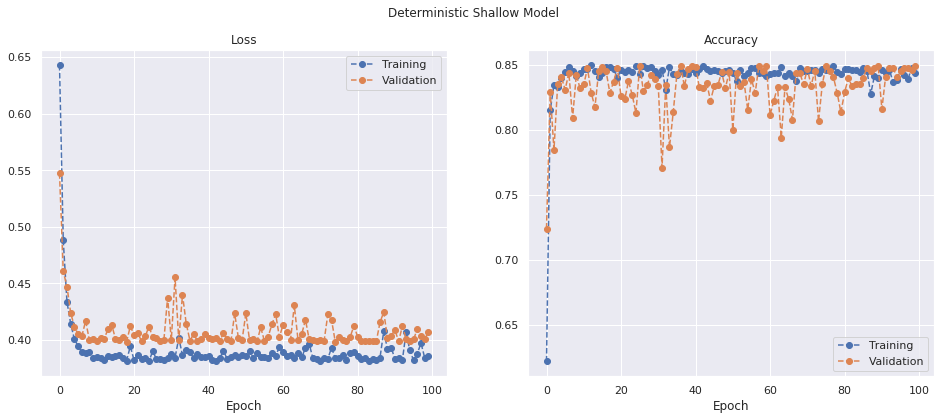

In [15]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    title='Deterministic Shallow Model',
    learning_rate=0.1)

Loss: 0.3675
Accuracy: 0.8520


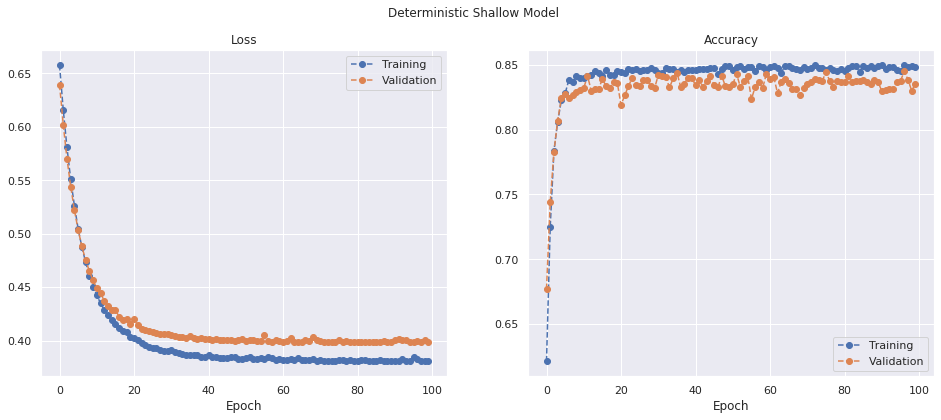

In [16]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    title='Deterministic Shallow Model',
    learning_rate=0.01)

Loss: 0.4326
Accuracy: 0.8470


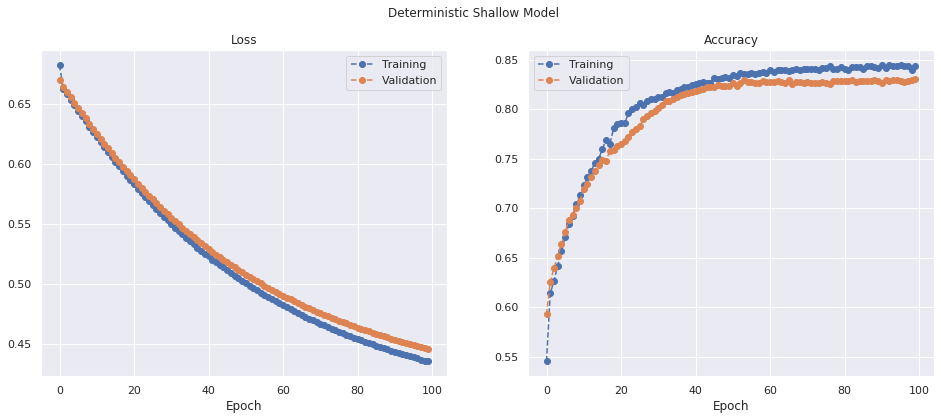

In [17]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    title='Deterministic Shallow Model',
    learning_rate=0.001)

# Deterministic Deep Model

In [18]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfkl.Dense(128),
    tfkl.ReLU(),
    tfkl.Dense(n_classes),
    tfkl.Softmax(),
])

initial_weights = model.get_weights()

Loss: 0.3402
Accuracy: 0.8605


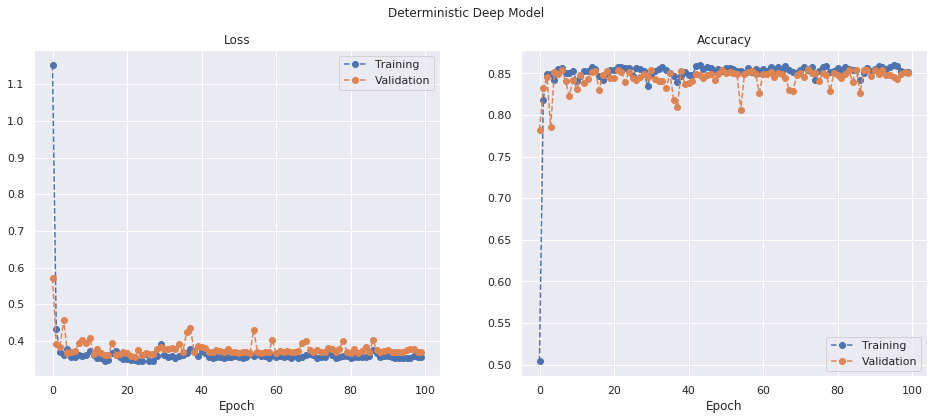

In [19]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    title='Deterministic Deep Model',
    learning_rate=0.1)

Loss: 0.1772
Accuracy: 0.9320


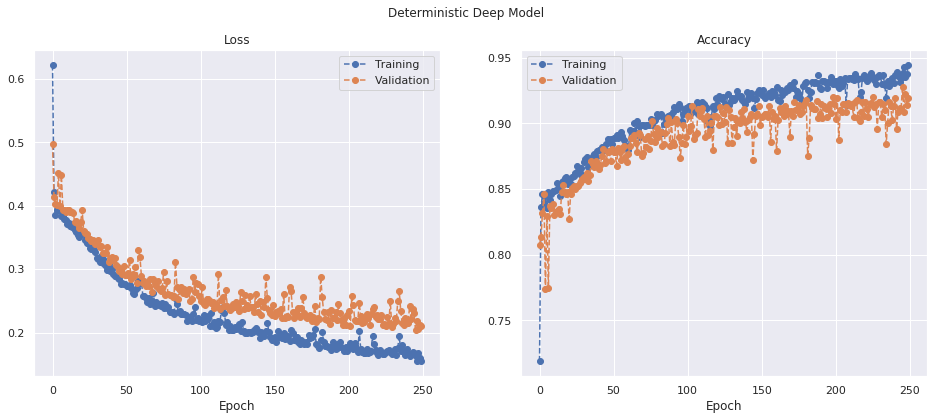

In [22]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    title='Deterministic Deep Model',
    learning_rate=0.01,
    epochs=250)

Loss: 0.1644
Accuracy: 0.9385


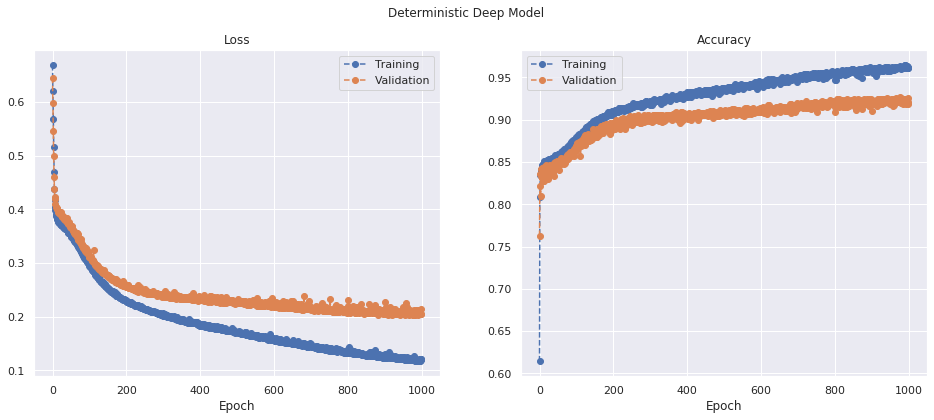

In [25]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    title='Deterministic Deep Model',
    learning_rate=0.001,
    epochs=1000)

# Create probabilistic model
*  [Probabilistic Layer Regression](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
*  [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical)

In [26]:
kl_weight = 1 / len(x_train)
print(kl_weight)

0.00016666666666666666


In [27]:
def negative_log_likelihood(y_true, y_pred_rv):
    return -y_pred_rv.log_prob(y_true)

In [28]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    # NOTE When c = np.log(np.expm1(1.)), training is very unstable
    # c = np.log(np.expm1(1.))
    c = 0
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
  ])

In [29]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
    ])

# Bayesian Shallow Model

In [30]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(n_classes) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(n_classes),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 63        
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
one_hot_categorical (OneHotC ((None, 2), (None, 2))    0         
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


Loss: 0.3891
Accuracy: 0.7700


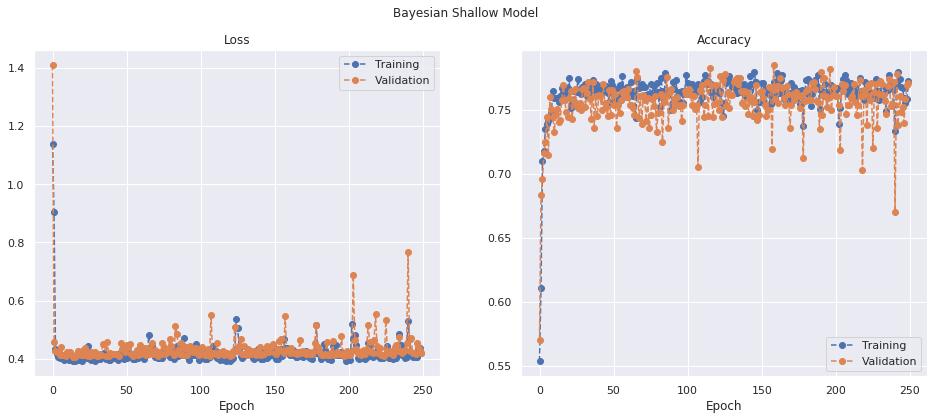

In [33]:
model.set_weights(initial_weights)

run_experiment(
    model,
    negative_log_likelihood,
    'Bayesian Shallow Model',
    learning_rate=0.5,
    epochs=250)

Loss: 0.3767
Accuracy: 0.7685


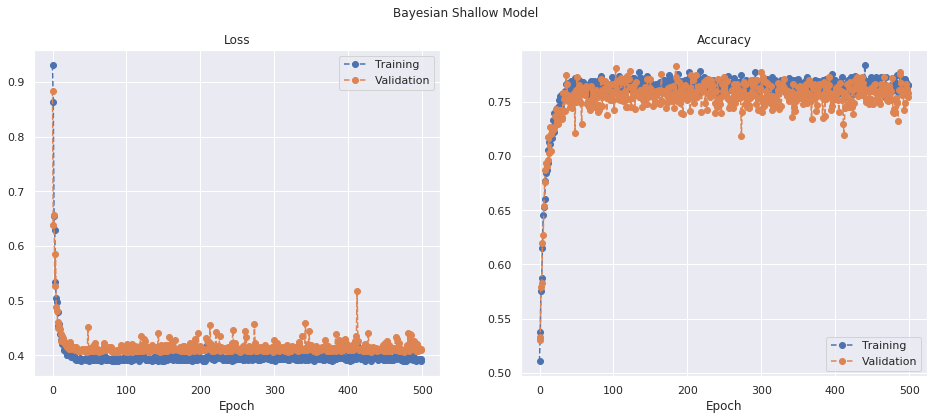

In [35]:
model.set_weights(initial_weights)

run_experiment(
    model,
    negative_log_likelihood,
    'Bayesian Shallow Model',
    learning_rate=0.1,
    epochs=500)

Loss: 0.3759
Accuracy: 0.7655


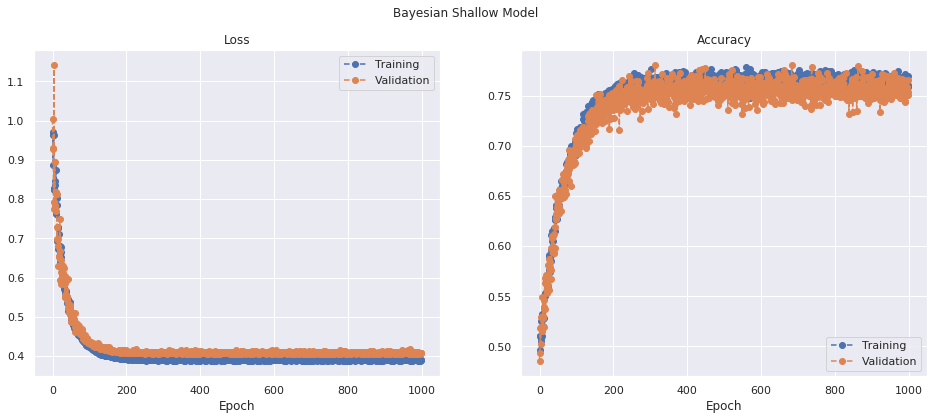

In [36]:
model.set_weights(initial_weights)

run_experiment(
    model,
    negative_log_likelihood,
    'Bayesian Shallow Model',
    learning_rate=0.01,
    epochs=1000)

# Deep Bayesian Model

In [37]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=128,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfkl.ReLU(),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(n_classes) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(n_classes),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_1 (DenseVa (None, 128)               8064      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_variational_2 (DenseVa (None, 1)                 387       
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 2), (None, 2))    0         
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


Loss: 0.8588
Accuracy: 0.5200


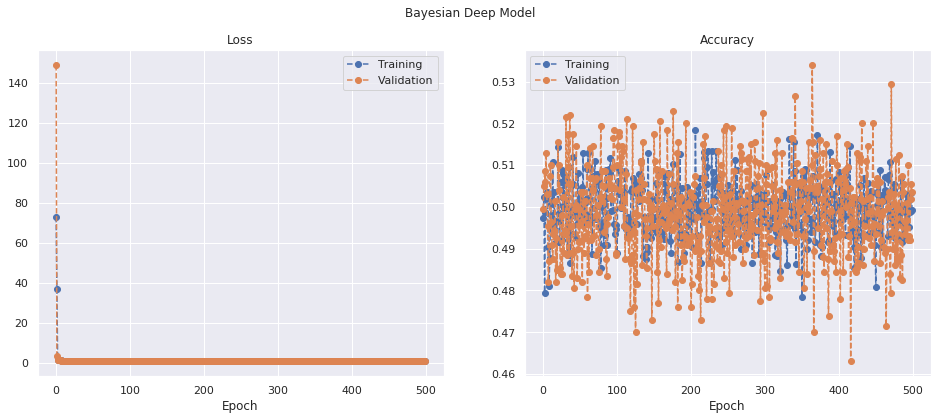

In [42]:
model.set_weights(initial_weights)

run_experiment(
    model,
    negative_log_likelihood,
    'Bayesian Deep Model',
    learning_rate=0.5,
    epochs=500)

Loss: 0.3824
Accuracy: 0.7995


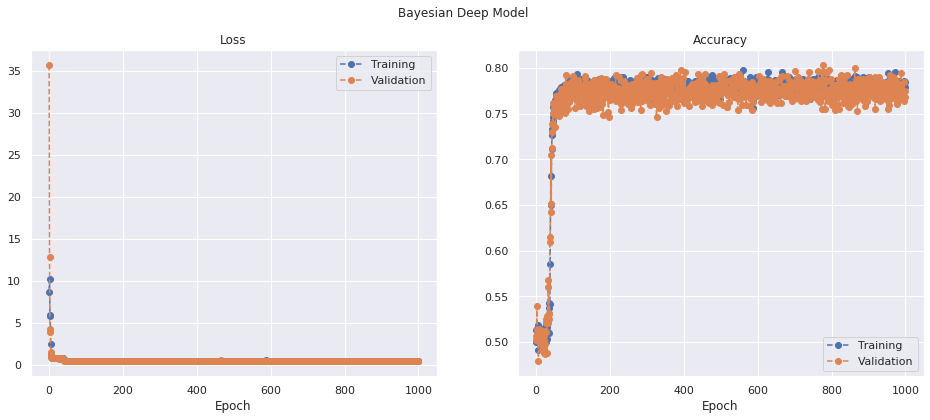

In [43]:
model.set_weights(initial_weights)

run_experiment(
    model,
    negative_log_likelihood,
    'Bayesian Deep Model',
    learning_rate=0.1,
    epochs=1000)

Loss: 0.3840
Accuracy: 0.7715


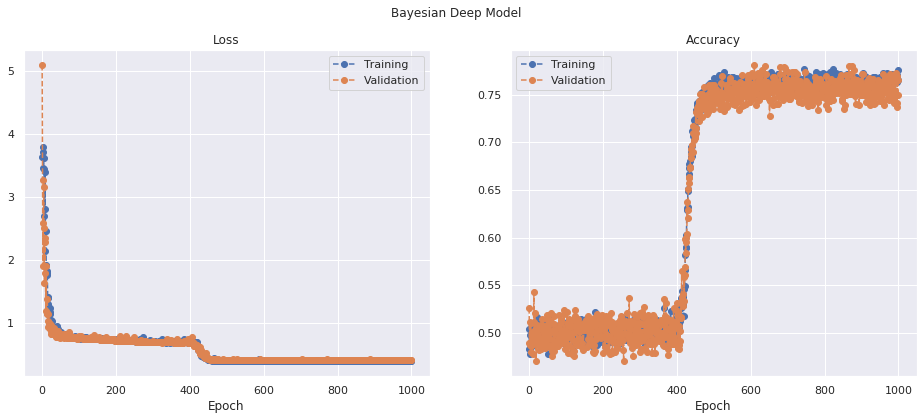

In [44]:
model.set_weights(initial_weights)

run_experiment(
    model,
    negative_log_likelihood,
    'Bayesian Deep Model',
    learning_rate=0.01,
    epochs=1000)